# Imports

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Add, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
from dataset.utils import load_coco, load_image, print_progress_bar
from image_model.topic_layers import load_topic_model, load_feature_model

# Load Data

In [4]:
# Folder containing the datset
data_dir = 'dataset/'

In [5]:
train_data, val_data, test_data, category_id, id_category = load_coco(
    os.path.join(data_dir, 'coco_raw.pickle'), 'captions'
)

In [6]:
train_images, train_captions = train_data  # Load training data
val_images, val_captions = val_data  # Load validation data
test_images, test_captions = test_data  # Load test data

In [7]:
num_classes = len(id_category)
num_classes

80

In [8]:
num_images_train = len(train_images)
num_images_train

19324

In [9]:
num_images_val = len(val_images)
num_images_val

2415

### Display a sample image

A young person riding a wave on a surfboard.
A person surfing in the ocean at the top of a wave
A man surfing over a white foam wave in the ocean.
A surfer catches air while surfing a wave.
Surfer kicks up a lot of water at the height of riding a wave.


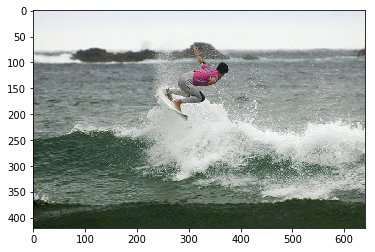

In [10]:
# display image
idx = 10

for caption in train_captions[idx]:
    print(caption)

plt.imshow(load_image(os.path.join(data_dir, train_images[idx])))
plt.show()

# Load Pre-Trained Image Model

In [11]:
# Load the pre-trained topic model
weights_path = os.path.join(os.getcwd(), 'topic_extraction', 'weights', 'checkpoint.keras')
topic_model = load_topic_model(num_classes, weights_path)
topic_model.summary()

Error trying to load weights.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 4096)              139570240 
_________________________________________________________________
dense (Dense)                (None, 80)                327760    
Total params: 139,898,000
Trainable params: 327,760
Non-trainable params: 139,570,240
_________________________________________________________________


In [12]:
# Load the pre-trained feature extractor model
feature_model = load_feature_model()

### Process Images

In [13]:
def process_images(topic_model, feature_model, data_dir, filenames, batch_size):
    """
    Process all the given files in the given data_dir using the
    pre-trained topic-model as well as the feature-model and return
    their transfer-values.
    
    The images are processed in batches to save
    memory and improve efficiency.
    """
    
    # Number of images to process.
    num_images = len(filenames)
    
    # Get the expected input size of the pre-trained network
    img_size = K.int_shape(topic_model.input)[1:3]

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float32)

    # Pre-allocate output-array for transfer-values.
    topic_transfer_values = np.zeros(
        shape=(num_images,) + K.int_shape(topic_model.output)[1:],
        dtype=np.float32
    )
    feature_transfer_values = np.zeros(
        shape=(num_images, K.int_shape(feature_model.output)[1]),
        dtype=np.float32
    )

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress_bar(start_index, num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)
            
            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained models to process the image.
        topic_transfer_values_batch = topic_model.predict(
            image_batch[0:current_batch_size]
        )
        # topic_transfer_values_batch = (topic_predictions > 0.5).astype('int')
        
        feature_transfer_values_batch = feature_model.predict(
            image_batch[0:current_batch_size]
        )

        # Save the transfer-values in the pre-allocated arrays.
        topic_transfer_values[start_index:end_index] = topic_transfer_values_batch[0:current_batch_size]
        feature_transfer_values[start_index:end_index] = feature_transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return topic_transfer_values, feature_transfer_values

In [14]:
def process_data(topic_model, feature_model, data_dir, data_type, filenames, captions, batch_size):
    print('Processing {0} images in training-set ...'.format(len(filenames)))

    # Path for the cache-file.
    cache_path_dir = os.path.join(data_dir, 'processed_caption_data')
    topic_cache_path = os.path.join(
        cache_path_dir, 'topic_transfer_values_{}.pkl'.format(data_type)
    )
    feature_cache_path = os.path.join(
        cache_path_dir, 'feature_transfer_values_{}.pkl'.format(data_type)
    )
    captions_cache_path = os.path.join(
        cache_path_dir, 'captions_{}.pkl'.format(data_type)
    )
    
    # Check if directory to store processed data exists
    if not os.path.exists(cache_path_dir):
        print('Directory created:', cache_path_dir)
        os.mkdir(cache_path_dir)

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    if os.path.exists(topic_cache_path) and os.path.exists(feature_cache_path) and os.path.exists(captions_cache_path):
        with open(topic_cache_path, mode='rb') as file:
            topic_obj = pickle.load(file)
        with open(feature_cache_path, mode='rb') as file:
            feature_obj = pickle.load(file)
        with open(captions_cache_path, mode='rb') as file:
            captions = pickle.load(file)
        print("Data loaded from cache-file.")
    else:
        topic_obj, feature_obj = process_images(
            topic_model, feature_model, data_dir, filenames, batch_size
        )
        with open(topic_cache_path, mode='wb') as file:
            pickle.dump(topic_obj, file)
        with open(feature_cache_path, mode='wb') as file:
            pickle.dump(feature_obj, file)
        with open(captions_cache_path, mode='wb') as file:
            pickle.dump(captions, file)
        print("Data saved to cache-file.")

    return topic_obj, feature_obj, captions

In [15]:
process_batch_size = 128

In [16]:
%%time
topic_transfer_values_train, feature_transfer_values_train, captions_train = process_data(
    topic_model, feature_model, data_dir, 'train', train_images, train_captions, process_batch_size
)
print("topic shape:", topic_transfer_values_train.shape)
print("feature shape:", feature_transfer_values_train.shape)

Processing 19324 images in training-set ...
Data loaded from cache-file.
topic shape: (19324, 80)
feature shape: (19324, 4096)
CPU times: user 64.9 ms, sys: 466 ms, total: 531 ms
Wall time: 3.15 s


In [17]:
%%time
topic_transfer_values_val, feature_transfer_values_val, captions_val = process_data(
    topic_model, feature_model, data_dir, 'val', val_images, val_captions, process_batch_size
)
print("topic shape:", topic_transfer_values_val.shape)
print("feature shape:", feature_transfer_values_val.shape)

Processing 2415 images in training-set ...
Data loaded from cache-file.
topic shape: (2415, 80)
feature shape: (2415, 4096)
CPU times: user 14.8 ms, sys: 56.5 ms, total: 71.3 ms
Wall time: 455 ms


# Tokenizer

In [18]:
mark_start = 'startseq '
mark_end = ' endseq'

In [19]:
def mark_captions(captions_list):
    """ Mark all the captions with the start and the end marker """
    captions_marked = [
        [mark_start + caption + mark_end for caption in captions] for captions in captions_list
    ]
    
    return captions_marked

In [20]:
captions_train_marked = mark_captions(captions_train)
print('Marked captions:')
captions_train_marked[0]

Marked captions:


['startseq A skateboarder about to slide down a skateboarding ramp endseq',
 'startseq A skateboarder attempts to slide down a paved slope. endseq',
 'startseq A skateboarder going down a cement ramp in a park endseq',
 'startseq A little boy skating at a skate park. endseq',
 'startseq A young man riding his skateboard down into a bowl. endseq']

In [21]:
def flatten(captions_list):
    """ Flatten all the captions into a single list """
    caption_list = [caption
                    for caption_list in captions_list
                    for caption in caption_list]
    
    return caption_list

In [22]:
captions_train_flat = flatten(captions_train_marked)

Create the tokenizer

In [23]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions_train_flat)

CPU times: user 1.94 s, sys: 5.2 ms, total: 1.95 s
Wall time: 1.94 s


In [24]:
# Get integer token for the start marker
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

In [25]:
# Get integer token for the end marker
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

In [26]:
# Numbers of words in the vocabulary
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8682

In [27]:
# Max length of each caption
max_tokens = 16

# Data Generator

In [28]:
def create_sequences(tokenizer, max_length, topic_transfer_value, feature_transfer_value, caption):
    """ Create sequences of topic_values, feature_values, input sequence and output sequence for an image """
    topic_values, feature_values = [], []
    input_captions, output_captions = [], []
    integer_sequence = tokenizer.texts_to_sequences([caption])[0]  # encode the sequence
    
    for idx in range(1, len(integer_sequence)):
        in_seq, out_seq = integer_sequence[:idx], integer_sequence[idx]  # split into input and output pair
        in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post', truncating='post')[0]  # pad input sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]  # encode output sequence
        
        # store
        topic_values.append(topic_transfer_value)
        feature_values.append(feature_transfer_value)
        input_captions.append(in_seq)
        output_captions.append(out_seq)
        
    return topic_values, feature_values, input_captions, output_captions

In [29]:
def batch_generator(topic_transfer_values, feature_transfer_values, captions_list, tokenizer, num_images, batch_size, max_length, vocab_size):
    """
    Generator function for creating random batches of training-data.
    
    It selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the dataset.
        indices = np.random.randint(num_images, size=batch_size)
        
        # For a batch of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random
        topic_values, feature_values = [], []
        input_captions, output_captions = [], []
        for idx in indices:
            topic_value, feature_value, input_caption, output_caption = create_sequences(
                tokenizer,
                max_length,
                topic_transfer_values[idx],
                feature_transfer_values[idx],
                np.random.choice(captions_list[idx])
            )
            topic_values.extend(topic_value)
            feature_values.extend(feature_value)
            input_captions.extend(input_caption)
            output_captions.extend(output_caption)

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = {
            'caption_input': np.array(input_captions),
            'topic_input': np.array(topic_values),
            'feature_input': np.array(feature_values)
        }

        # Dict for the output-data.
        y_data = {
            'caption_output': np.array(output_captions)
        }
        
        yield (x_data, y_data)

In [30]:
batch_size = 10

In [31]:
generator_train = batch_generator(
    topic_transfer_values_train,
    feature_transfer_values_train,
    captions_train_marked,
    tokenizer,
    num_images_train,
    batch_size,
    max_tokens,
    vocab_size
)
batch = next(generator_train)
batch_x = batch[0]
batch_y = batch[1]

In [32]:
# Example of the topic-transfer-values for the first image in the batch
batch_x['topic_input'][0]

array([9.98681724e-01, 5.21089940e-04, 1.29753444e-02, 5.23793324e-06,
       2.89571035e-05, 1.85278861e-03, 1.82209514e-15, 7.84580875e-03,
       8.62166518e-04, 3.19929750e-05, 1.15339812e-04, 1.64908910e-04,
       1.18458594e-08, 1.85643137e-02, 2.49123132e-05, 6.43967505e-05,
       1.61805120e-03, 2.88942044e-08, 6.07538071e-23, 5.00583117e-11,
       6.26393160e-08, 2.78609456e-08, 1.73359175e-27, 5.52410055e-25,
       5.92022156e-03, 2.98167043e-03, 1.02583144e-03, 1.56934912e-04,
       1.61641801e-05, 1.52625535e-02, 1.37201184e-03, 2.42508366e-03,
       5.61071932e-01, 7.77572095e-02, 6.66037649e-02, 2.62480769e-02,
       3.44596170e-02, 7.71755702e-04, 8.73074472e-01, 1.21836970e-03,
       4.40830801e-04, 5.33059247e-05, 1.24437006e-12, 8.85050136e-21,
       8.10540251e-27, 1.90807967e-07, 9.50861789e-09, 1.52391169e-10,
       1.49323601e-19, 2.54469110e-23, 3.03723836e-26, 2.58307159e-21,
       3.74749187e-15, 2.14279581e-23, 5.03552941e-25, 7.01246380e-15,
      

In [33]:
# Example of the feature-transfer-values for the first image in the batch
batch_x['feature_input'][0]

array([0.6755041 , 0.04049107, 0.8552831 , ..., 0.        , 0.26427037,
       0.1770072 ], dtype=float32)

In [34]:
# Example of the token-sequence for the first image in the batch
# This is the input to the decoder-part of the neural network
batch_x['caption_input'][0]

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [35]:
# This is the token-sequence for the output of the decoder
# Note how it is the same as the sequence above, except it is shifted one time-step
batch_y['caption_output'][0]

array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)

In [36]:
# Shape of the output
batch_y['caption_output'].shape

(113, 8682)

## Steps Per Epoch

One epoch is a complete processing of the training-set. We would like to process each image and caption pair only once per epoch. However, because each batch is chosen completely at random in the above batch-generator, it is possible that an image occurs in multiple batches within a single epoch, and it is possible that some images may not occur in any batch at all within a single epoch.

Nevertheless, we still use the concept of an 'epoch' to measure approximately how many iterations of the training-data we have processed. But the data-generator will generate batches for eternity, so we need to manually calculate the approximate number of batches required per epoch.

In [37]:
# Number of captions for each image in the training-set
num_captions_train = [len(captions) for captions in captions_train]

# Total number of captions in the training-set
total_num_captions_train = np.sum(num_captions_train)

# Approximate number of batches required per epoch,
# if we want to process each caption and image pair once per epoch
steps_per_epoch_train = int(total_num_captions_train / batch_size)
steps_per_epoch_train

9666

# Create Model

### Create pre-trained Embedding Layer

In [38]:
def read_glove_vecs(glove_file):
    print('Creating word to vec map...')
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float32)
    print('Done!')
    return word_to_vec_map

In [39]:
# load embeddings
word_to_vec_map = read_glove_vecs('{}/glove.6B.300d.txt'.format(data_dir))

Creating word to vec map...
Done!


In [40]:
# assign embeddings values to custom tokens
size = word_to_vec_map['unk'].shape

word_to_vec_map[mark_start.strip()] = np.random.uniform(low=-1.0, high=1.0, size=size)
word_to_vec_map[mark_end.strip()] = np.random.uniform(low=-1.0, high=1.0, size=size)

In [41]:
def create_embedding_layer(word_to_index, word_to_vec_map, num_words):
    """ Create a Keras Embedding() layer and load in pre-trained GloVe 100-dimensional vectors
        @params:
        :word_to_index -- dictionary containing the each word mapped to its index
        :word_to_vec_map -- dictionary mapping words to their GloVe vector representation
        :num_words -- number of words in the vocabulary
        
        @return:
        :decoder_embedding -- pretrained layer Keras instance
    """
    
    vocabulary_length = num_words + 1  # adding 1 to fit Keras embedding (requirement)
    embedding_dimensions = word_to_vec_map['unk'].shape[0]  # define dimensionality of GloVe word vectors (= 300)
    
    embedding_matrix = np.zeros((vocabulary_length, embedding_dimensions))  # initialize with zeros
    for word, index in word_to_index.items():
        try:
            embedding_matrix[index, :] = word_to_vec_map[word]
        except KeyError:
            embedding_matrix[index, :] = word_to_vec_map['unk']
    
    # we don't want the embeddings to be updated, thus trainable parameter is set to False
    decoder_embedding = Embedding(
        input_dim=vocabulary_length,
        output_dim=embedding_dimensions,
        trainable=False,
        name='decoder_embedding'
    )
    decoder_embedding.build((None,))
    decoder_embedding.set_weights([embedding_matrix])  # with this the layer is now pretrained
    
    return decoder_embedding

### Define some global values

In [42]:
# Internal state-sizes of LSTMs
state_size = 256

In [ ]:
K.clear_session()

## Encode Images

In [43]:
# Input layer to receive the predictions from the feature model
feature_input = Input(
    shape=K.int_shape(feature_model.output)[1:], name='feature_input'
)

In [44]:
# Reshape feature transfer values
image_model_output = Dense(state_size, activation='relu', name='image_model_output')(feature_input)
image_model_output

<tf.Tensor 'image_model_output/Relu:0' shape=(?, 256) dtype=float32>

## Encode Captions

### Create model to encode captions

Define layers

In [45]:
# This inputs topic-transfer-values to the LSTM
topic_input = Input(
    shape=K.int_shape(topic_model.output)[1:], name='topic_input'
)

In [46]:
# Input for token-sequences to the decoder
# Using 'None' in the shape means that the token-sequences can have arbitrary lengths
caption_input = Input(shape=(None,), name='caption_input')

In [47]:
# Embedding-layer which converts sequences of integer-tokens to sequences of vectors
caption_embedding = create_embedding_layer(tokenizer.word_index, word_to_vec_map, vocab_size)

In [48]:
# The LSTM layer for the input captions
caption_lstm = LSTM(state_size, name='caption_lstm')

Connect the layers

In [49]:
# Reshape the topic transfer values to 3D tensor in-order to feed it to the LSTM
topic_input_reshaped = Reshape(
    target_shape=(K.int_shape(topic_input)[1:] + (1,))
)(topic_input)

In [50]:
# Feed topic to LSTM
_, initial_state_h0, initial_state_c0 = LSTM(
    state_size, return_state=True, name='topic_lstm'
)(topic_input_reshaped)

topic_lstm_states = [initial_state_h0, initial_state_c0]

In [51]:
net = caption_input  # Start the decoder-network with its input-layer
net = caption_embedding(net)  # Connect the embedding-layer
caption_model_output = caption_lstm(net, initial_state=topic_lstm_states) # Connect the caption LSTM layer
caption_model_output

<tf.Tensor 'caption_lstm/TensorArrayReadV3:0' shape=(?, 256) dtype=float32>

## Merge the image and the caption model

In [52]:
# Concat the outputs of both the models
merge_net = Add()([image_model_output, caption_model_output])

In [53]:
merge_net = Dense(state_size, activation='relu')(merge_net)
outputs = Dense(vocab_size, activation='softmax', name='caption_output')(merge_net)
outputs

<tf.Tensor 'caption_output/Softmax:0' shape=(?, 8682) dtype=float32>

# Create the Training Model

In [54]:
model = Model(
    inputs=[feature_input, topic_input, caption_input],
    outputs=outputs
)

In [55]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
topic_input (InputLayer)        (None, 80)           0                                            
__________________________________________________________________________________________________
caption_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 80, 1)        0           topic_input[0][0]                
__________________________________________________________________________________________________
feature_input (InputLayer)      (None, 4096)         0                                            
__________________________________________________________________________________________________
decoder_em

## Compile the Training Model

In [56]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

### Callback Functions

In [57]:
path_checkpoint = 'weights/checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [58]:
callback_tensorboard = TensorBoard(log_dir='./weights/logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [59]:
callbacks = [callback_checkpoint, callback_tensorboard]

### Load Checkpoint

In [60]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

### Train the Model

In [ ]:
%%time
model.fit_generator(
    generator=generator_train,
    steps_per_epoch=steps_per_epoch_train,
    epochs=20,
    callbacks=callbacks
)

# Generate Captions

In [83]:
def generate_caption(image_path, topic_model, feature_model, caption_model, tokenizer, max_tokens):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    img_size = K.int_shape(topic_model.input)[1:3]
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Get image model predictions
    topic_values = topic_model.predict(image_batch)
    feature_values = feature_model.predict(image_batch)
    
    # Start with the initial start token
    predicted_caption = 'startseq'
    
    # Input for the caption model
    x_data = {
        'topic_input': topic_values,
        'feature_input': feature_values
    }
    
    for i in range(max_tokens):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([predicted_caption])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_tokens)
        # predict next word
        x_data['caption_input'] = np.array(sequence)
        y_pred = caption_model.predict(x_data, verbose=0)
        # convert probability to integer
        y_pred = np.argmax(y_pred)
        # map integer to word
        word = tokenizer.index_word[y_pred]
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        predicted_caption += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(predicted_caption)
    print()

In [84]:
idx = 12
image_path = 'dataset/' + val_images[idx]

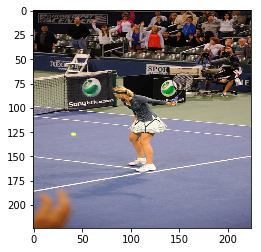

Predicted caption:
startseq 10 pike pike mustaches chunk retrieves pike shadowed pebble endseq



In [85]:
generate_caption(image_path, topic_model, feature_model, model, tokenizer, max_tokens)